# Problem Set 4

In [34]:
import numpy as np

import pandas as pd

import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import linear_model

#convenient for running multiple linear regression with few lines of code
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
%matplotlib inline

## Import Movie data

In [51]:
data = pd.read_csv("allData.tsv", sep='\t')
data.head()

,userID,age,gender,movieID,name,year,genre1,genre2,genre3,rating
0,747,1,F,1193,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,5
1,747,1,F,661,James and the Giant Peach,1996,Animation,Children's,Musical,3
2,747,1,F,2804,"Christmas Story, A",1983,Comedy,Drama,NaN,5
3,747,1,F,919,"Wizard of Oz, The",1939,Adventure,Children's,Drama,4
4,747,1,F,2791,Airplane!,1980,Comedy,NaN,NaN,4


In [50]:
data.dtypes

userID      int64
age         int64
gender       int8
movieID     int64
name       object
year        int64
genre1       int8
genre2       int8
genre3       int8
rating      int64
dtype: object

## Handle categorical and missing data

In [37]:
# change NaN to 0
data[['gender', 'genre1', 'genre2', 'genre3']] = data[['gender', 'genre1', 'genre2', 'genre3']].fillna(0)
#data.head()

In [38]:
# convert to categorical columns
data["gender"] = data["gender"].astype('category')
data["genre1"] = data["genre1"].astype('category')
data["genre2"] = data["genre2"].astype('category')
data["genre3"] = data["genre3"].astype('category')

#data.dtypes

In [39]:
cat_columns = data.select_dtypes(['category']).columns
#cat_columns

In [40]:
map_gender = dict( enumerate(data['gender'].cat.categories) )
map_genre1 = dict( enumerate(data['genre1'].cat.categories) )
map_genre2 = dict( enumerate(data['genre2'].cat.categories) )
map_genre3 = dict( enumerate(data['genre3'].cat.categories) )

#print(map_genre2)

In [41]:
#data[cat_columns]
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
#data.head()

# Problem C: Fit a multiple linear regression model 

In [33]:
data.shape

age = data["age"]
gender = data["gender"]
release_year = data["year"]
genre1 = data["genre1"]
genre2 = data["genre2"]
genre3 = data["genre3"]
rating = data["rating"]

lm1 = smf.ols(formula='rating ~ age + gender + year + genre1 + genre2 + genre3', data=data).fit()
#view model summary
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     179.8
Date:                Fri, 26 Oct 2018   Prob (F-statistic):          5.58e-226
Time:                        00:13:54   Log-Likelihood:                -47829.
No. Observations:               31620   AIC:                         9.567e+04
Df Residuals:                   31613   BIC:                         9.573e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.5310      0.816     32.503      0.000      24.931      28.131
age            0.0022      0.001      4.092      0.000       0.001       0.003
gender         0.0086      0.015      0.592      0.554      -0.020       0.037
year          -0.0117      0.000    -28.479      0.000      -0.012      -0.011
genre1         0.0188      0.002      9.206      0.000       0.015       0.023
genre2         0.0054      0.001      5.034      0.000       0.003       0.008
genre3         0.0012      0.001      0.950      0.342      -0.001       0.004
==============================================================================
Omnibus:                     1524.052   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1637.676
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                       2.676   Cond. No.                     2.62e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Only about three percent of the variation in rating is exlained by the predictors. Gender and Genre3 are particularly not significant

In [42]:
#fit the model with gender and genre3 exlcuded
lm2 = smf.ols(formula='rating ~ age + year + genre1 + genre2', data=data).fit()
#view model summary
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     269.4
Date:                Fri, 26 Oct 2018   Prob (F-statistic):          3.89e-228
Time:                        00:19:37   Log-Likelihood:                -47830.
No. Observations:               31620   AIC:                         9.567e+04
Df Residuals:                   31615   BIC:                         9.571e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.6195      0.812     32.792      0.000      25.028      28.211
age            0.0022      0.001      4.108      0.000       0.001       0.003
year          -0.0117      0.000    -28.701      0.000      -0.012      -0.011
genre1         0.0179      0.002      9.704      0.000       0.014       0.022
genre2         0.0055      0.001      5.134      0.000       0.003       0.008
==============================================================================
Omnibus:                     1524.167   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1638.456
Skew:                          -0.534   Prob(JB):                         0.00
Kurtosis:                       2.676   Cond. No.                     2.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The model is still not optimal...analyze plots of predictors against the dependent

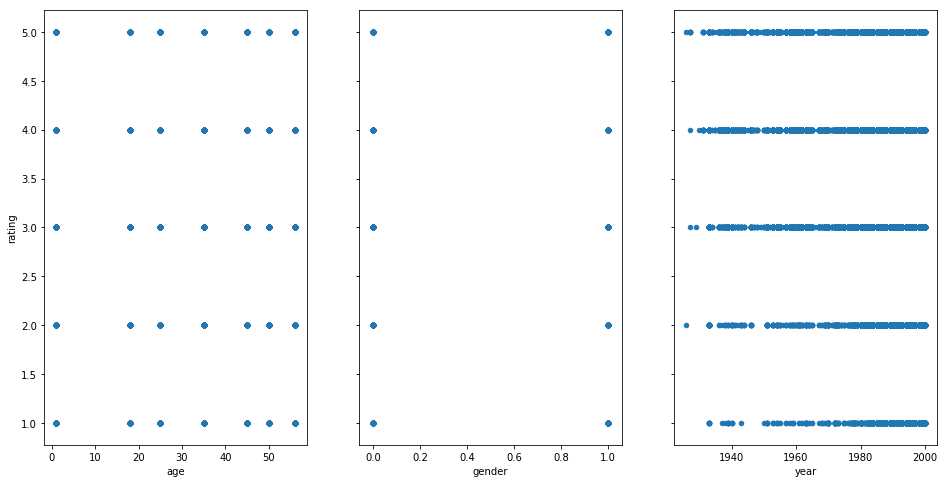

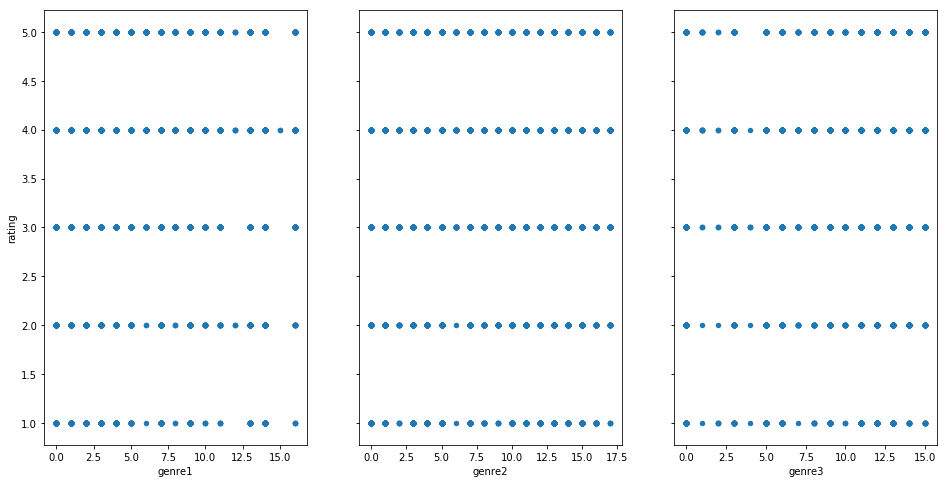

In [49]:
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='age', y='rating', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='gender', y='rating', ax=axs[1])
data.plot(kind='scatter', x='year', y='rating', ax=axs[2])

fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='genre1', y='rating', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='genre2', y='rating', ax=axs[1])
data.plot(kind='scatter', x='genre3', y='rating', ax=axs[2])

#### The plots suggest linear regression might not be useful in this context

## Problem D: Look at the regression coefficients
Print the regression coefficients (intercept and slope) and in a markdown cell comment about their values. Do they make sense? What do they tell you?

In [6]:
# The coefficients
print('Intercept: ', lm.intercept_)
print('Coefficients: ', lm.coef_)

Intercept:  0.928986660842
Coefficients:  [ 0.53065647]


- The Intercept of 0.93 tells us the average minimum dollar amount that everybody tips, can be seen as a fix tip, independent of the distance driven. 
- The slope of 0.53 tells us that with every mile, the tip increases by 0.53 \$ on average

The values make sense, as the absolute tip amount should increase with travel time / distance travelled. Also, the mininum amount makes sense, e.g. as courtesy or for distance independent taxi driver tasks like loading luggage in the trunk. 

## Problem E: Evaluate the model
Just because the model fit the data set doesn't mean it's very predictive. Run a 10-fold cross-validation and compute the average mean absolute deviation. Show the result. In a markdown cell comment on what that number means in terms of predictive accuracy.

In [7]:
# Linear model
lm = LinearRegression(fit_intercept=True)
# 10-fold cross validation
scores = cross_validate(lm, X, y, cv=10, scoring=('neg_mean_absolute_error'), return_train_score=False)

# calculate average mean absolute deviation
print("Average mean absolute deviation:", np.mean(-1*scores['test_score']))

Average mean absolute deviation: 0.717577057443


What does that number mean in terms of predictive accuracy? 
- Mean absolute devation (MAD) takes the absolute value of forecast errors and averages them over the entirety of the forecast time periods, and here our 10 cross validation runs.

- Since this metric is in the same metric, we can say that the average tip deviation from realized tips and predictions is 72 dollar cents. 
- In terms of predictive accuracy our predictions deviate from the true realized value by 72 dollar cents, on average.